In [1]:
#!pip install opencv-python

In [1]:
%reload_ext watermark
%watermark -v -p os,glob,cv2,shutil,joblib,gc,random,re,tensorflow,numpy,tqdm,matplotlib,pandas,sklearn,datetime,random,warning

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.34.0

os        : unknown
glob      : unknown
cv2       : 4.6.0
shutil    : unknown
joblib    : 1.1.0
gc        : unknown
random    : unknown
re        : 2.2.1
tensorflow: 2.8.0
numpy     : 1.22.3
tqdm      : 4.63.1
matplotlib: 3.5.1
pandas    : 1.4.1
sklearn   : 1.0.2
datetime  : unknown



In [2]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-15 07:41:22.124478


In [3]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,font=cv2.FONT_HERSHEY_SIMPLEX):
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(data[i,:,:,0],cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        
        pred_img=cv2.cvtColor(data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate([label_vis(data,i, font) 
                    for i in range((BATCH_SIZE*idx),
                                   (np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn

# 자료 상태 확인

In [4]:
files=glob.glob("/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/**/seg/*.png")

In [5]:
"비율 확인"
print({"total":4291,"open":1599,"closing":1906,"closed":786})
len([j for j in [i for i in files if re.compile('raw').findall(i)] if re.compile('closed').findall(j)])
len([j for j in [i for i in files if re.compile('mask').findall(i)] if re.compile('closed').findall(j)])
f"open : {1599/4291*100:.02f}% closing : {1906/4291*100:.02f}% closed : {786/4291*100:.02f}%"

{'total': 4291, 'open': 1599, 'closing': 1906, 'closed': 786}


'open : 37.26% closing : 44.42% closed : 18.32%'

# 모델링

In [6]:
files=glob.glob("/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/**/seg/*.png")
model_files=np.array(sorted([i for i in files if re.compile('raw').findall(i)]))
model_files=np.array([i for i in model_files if os.path.exists(f"/root/{os.path.realpath(i)}")])

In [7]:
def my_generator(files,shape=(240,320)):
    def img_load(file):
        try:
            img = cv2.imread(
                f"/root/{os.path.realpath(file)}", cv2.IMREAD_COLOR)# 심볼릭 링크
            img = cv2.resize(img,shape[::-1])
        except:
            img = cv2.imread(file, cv2.IMREAD_COLOR)
            img = cv2.resize(img,shape[::-1])
        return img
    
    def generator():
        for file in files:
            split_img=img_load(file)#[np.newaxis]
            y=np.zeros((3))
            if file.split('_')[-1].split('.')[0]=="open":
                y[0]=1
            elif file.split('_')[-1].split('.')[0]=="closing":
                y[1]=1
            else:
                y[2]=1
            yield split_img,y
    return generator

def my_cnn_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    cnn_model = tf.keras.Sequential()
    cnn_model.add(tf.keras.layers.Input((240,320,3)))
    cnn_model.add(tf.keras.layers.Rescaling(1./255))
    cnn_model.add(tf.keras.layers.Resizing(256,320,name='resize'))

    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(0.2))
    cnn_model.add(tf.keras.layers.Dense(3, activation='softmax'))
    return cnn_model

## 자료 확인

In [10]:
gen=my_generator(model_files)

In [11]:
x,y=next(iter(gen()))
# pred=model(x[np.newaxis]/255)

(<matplotlib.image.AxesImage at 0x7f942cc532e0>, array([0., 1., 0.]))

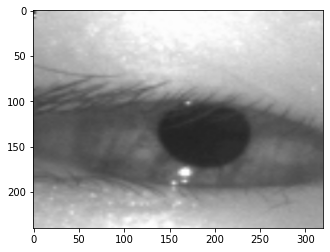

In [12]:
plt.imshow(x),y

## 모델링 수행

In [13]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320,3)
target_label=np.array(['open','closing','closed'])

tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(model_files),1):    
    for cutoff in np.arange(0,1.1,0.05):
        for target in target_label:
            cond=f"K_{K}_target_{target}_cutoff_{cutoff:.2f}"
            tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    train_files=model_files[train_idx]
    test_files=model_files[test_idx]
    train_files, valid_files=train_test_split(
        train_files, test_size=.2, random_state=42)
    train_files=sorted(train_files)
    valid_files=sorted(valid_files)
    test_files =sorted(test_files)
    print(f"train : {len(train_files)} test : {len(test_files)} valid : {len(valid_files)}")
    print("train", len([i for i in train_files if re.compile('open').findall(i)]),\
    len([i for i in train_files if re.compile('closing').findall(i)]),\
    len([i for i in train_files if re.compile('closed').findall(i)]))
    print("test",len([i for i in test_files if re.compile('open').findall(i)]),\
    len([i for i in test_files if re.compile('closing').findall(i)]),\
    len([i for i in test_files if re.compile('closed').findall(i)]))
    print("valid",len([i for i in valid_files if re.compile('open').findall(i)]),\
    len([i for i in valid_files if re.compile('closing').findall(i)]),\
    len([i for i in valid_files if re.compile('closed').findall(i)]))
    
    random.seed(42)
    tr_dataset=tf.data.Dataset.from_generator(
        my_generator(train_files),
        output_shapes=(output_shape, 3),
        output_types=(output_type, output_type))
    random.seed(42)
    te_dataset=tf.data.Dataset.from_generator(
        my_generator(test_files),
        output_shapes=(output_shape, 3),
        output_types=(output_type, output_type))
    random.seed(42)
    val_dataset=tf.data.Dataset.from_generator(
        my_generator(valid_files),
        output_shapes=(output_shape, 3),
        output_types=(output_type, output_type))

    tr_gen =tr_dataset.batch(64).prefetch(1)
    te_gen =te_dataset.batch(1).prefetch(1)
    val_gen=val_dataset.batch(64).prefetch(1)

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    model=my_cnn_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=.005),
        loss='categorical_crossentropy', 
        metrics=['accuracy'],
    )
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=20,
            mode='min'),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',patience=5,factor=0.1,
            mode='min')
    ]
    model.fit(tr_gen, epochs=30, validation_data=val_gen,
          verbose=1)
    for layer in model.layers[:-5]:
        layer.trainable=False    
    model.fit(tr_gen, epochs=90, validation_data=val_gen,
              verbose=1,callbacks=callbacks,class_weight={0:3,1:7,2:1})
    model.save(f'cnn_model_{K}_fold.h5')    
    ###################
    """
    모델 검증
    """
    for i,(x,y) in tqdm(enumerate(te_gen)):
        for target in range(3):
            y_true=y[:,target].numpy()
            y_pred=model.predict(x)[:,target].astype('float64')            
            for cutoff in np.arange(0,1.1,0.05):
                cond=f"K_{K}_target_{target_label[target]}_cutoff_{cutoff:.02f}"
                tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
                # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
                tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn

train : 2450 test : 1532 valid : 613
train 927 1054 469
test 600 683 249
valid 242 270 101


2022-11-15 07:41:41.209955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 07:41:41.214403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 07:41:41.214703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 07:41:41.215367: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/30


2022-11-15 07:41:42.812962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-11-15 07:41:44.222809: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 07:41:44.222895: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-15 07:41:44.222904: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

39/39 [==============================] - 15s 301ms/step - loss: 1.1316 - accuracy: 0.6245 - val_loss: 8.8143 - val_accuracy: 0.1876
Epoch 2/30
39/39 [==============================] - 9s 220ms/step - loss: 0.6234 - accuracy: 0.7139 - val_loss: 3.7570 - val_accuracy: 0.1664
Epoch 3/30
39/39 [==============================] - 9s 220ms/step - loss: 0.5408 - accuracy: 0.7527 - val_loss: 2.8123 - val_accuracy: 0.2463
Epoch 4/30
39/39 [==============================] - 9s 219ms/step - loss: 0.4864 - accuracy: 0.7759 - val_loss: 2.1690 - val_accuracy: 0.3589
Epoch 5/30
39/39 [==============================] - 9s 218ms/step - loss: 0.4701 - accuracy: 0.7873 - val_loss: 1.4997 - val_accuracy: 0.5008
Epoch 6/30
39/39 [==============================] - 9s 219ms/step - loss: 0.4281 - accuracy: 0.7988 - val_loss: 1.2886 - val_accuracy: 0.5416
Epoch 7/30
39/39 [==============================] - 9s 221ms/step - loss: 0.4073 - accuracy: 0.8098 - val_loss: 1.0883 - val_accuracy: 0.6346
Epoch 8/30
39/39

1532it [01:54, 13.40it/s]


train : 2450 test : 1532 valid : 613
train 960 1039 451
test 575 680 277
valid 234 288 91
Epoch 1/30
39/39 [==============================] - 9s 230ms/step - loss: 1.1849 - accuracy: 0.5914 - val_loss: 3.0034 - val_accuracy: 0.2382
Epoch 2/30
39/39 [==============================] - 9s 228ms/step - loss: 0.6292 - accuracy: 0.7118 - val_loss: 3.5477 - val_accuracy: 0.1501
Epoch 3/30
39/39 [==============================] - 9s 227ms/step - loss: 0.5755 - accuracy: 0.7367 - val_loss: 3.9725 - val_accuracy: 0.1485
Epoch 4/30
39/39 [==============================] - 9s 227ms/step - loss: 0.5737 - accuracy: 0.7371 - val_loss: 2.7360 - val_accuracy: 0.1811
Epoch 5/30
39/39 [==============================] - 9s 229ms/step - loss: 0.6138 - accuracy: 0.7249 - val_loss: 2.7176 - val_accuracy: 0.2692
Epoch 6/30
39/39 [==============================] - 9s 229ms/step - loss: 0.5450 - accuracy: 0.7571 - val_loss: 2.0843 - val_accuracy: 0.3931
Epoch 7/30
39/39 [==============================] - 9s 228

1532it [01:54, 13.39it/s]


train : 2451 test : 1531 valid : 613
train 940 1093 418
test 594 644 293
valid 235 270 108
Epoch 1/30
39/39 [==============================] - 10s 246ms/step - loss: 1.2333 - accuracy: 0.5736 - val_loss: 2.0197 - val_accuracy: 0.3442
Epoch 2/30
39/39 [==============================] - 9s 226ms/step - loss: 0.6591 - accuracy: 0.6940 - val_loss: 3.3798 - val_accuracy: 0.1941
Epoch 3/30
39/39 [==============================] - 9s 225ms/step - loss: 0.5954 - accuracy: 0.7250 - val_loss: 4.1352 - val_accuracy: 0.3556
Epoch 4/30
39/39 [==============================] - 9s 226ms/step - loss: 0.5617 - accuracy: 0.7356 - val_loss: 6.0143 - val_accuracy: 0.1533
Epoch 5/30
39/39 [==============================] - 9s 226ms/step - loss: 0.5303 - accuracy: 0.7621 - val_loss: 35.2080 - val_accuracy: 0.2855
Epoch 6/30
39/39 [==============================] - 9s 227ms/step - loss: 0.4857 - accuracy: 0.7772 - val_loss: 1.1675 - val_accuracy: 0.4617
Epoch 7/30
39/39 [==============================] - 9s 

1531it [01:54, 13.35it/s]


In [14]:
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tp=0;fn=0;fp=0
        for target in target_label:
            tp+=tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            fn+=fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            fp+=fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            tn+=tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
        tpr[K].append(tp/(tp+fn))
        fpr[K].append(fp/(fp+tn))
        
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

In [15]:
# joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'눈깜빡임지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('눈깜빡임지표.pkl')

In [16]:
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
roc_aucs=dict()
for target in target_label:
    tpr=dict();fpr=dict()
    for K in range(1,4):
        tpr[K]=list();fpr[K]=list()    
        for i in np.arange(0,1.1,.05):
            tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+\
                fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
            fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+\
                tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

    for K,color in zip(range(1,4),colors):
        roc_auc=metrics.auc(fpr[K],tpr[K])
        roc_aucs[f"{target}_{K}"]=roc_auc

In [17]:
roc_aucs

{'open_1': 0.8171530758226037,
 'open_2': 0.8230139475716688,
 'open_3': 0.8402470094038933,
 'closing_1': 0.7907252870054684,
 'closing_2': 0.7858481772990886,
 'closing_3': 0.8029735937313998,
 'closed_1': 0.9483639937771351,
 'closed_2': 0.9227192313777383,
 'closed_3': 0.9429554439341223}

In [14]:
np.mean(list(roc_aucs.values()))

0.8733209031813669

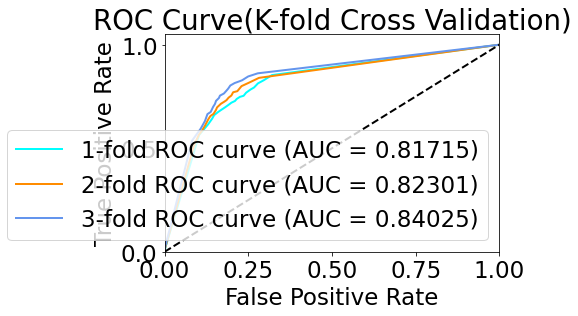

In [18]:
target="open"
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 23})
plt.figaspect(2)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()

In [16]:
import tensorflow as tf

def my_cnn_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    cnn_model = tf.keras.Sequential()
    cnn_model.add(tf.keras.layers.Input((240,320,3)))
    cnn_model.add(tf.keras.layers.Rescaling(1./255))
    cnn_model.add(tf.keras.layers.Resizing(256,320,name='resize'))

    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(0.2))
    cnn_model.add(tf.keras.layers.Dense(3, activation='softmax'))
    return cnn_model

In [17]:
model=my_cnn_model()

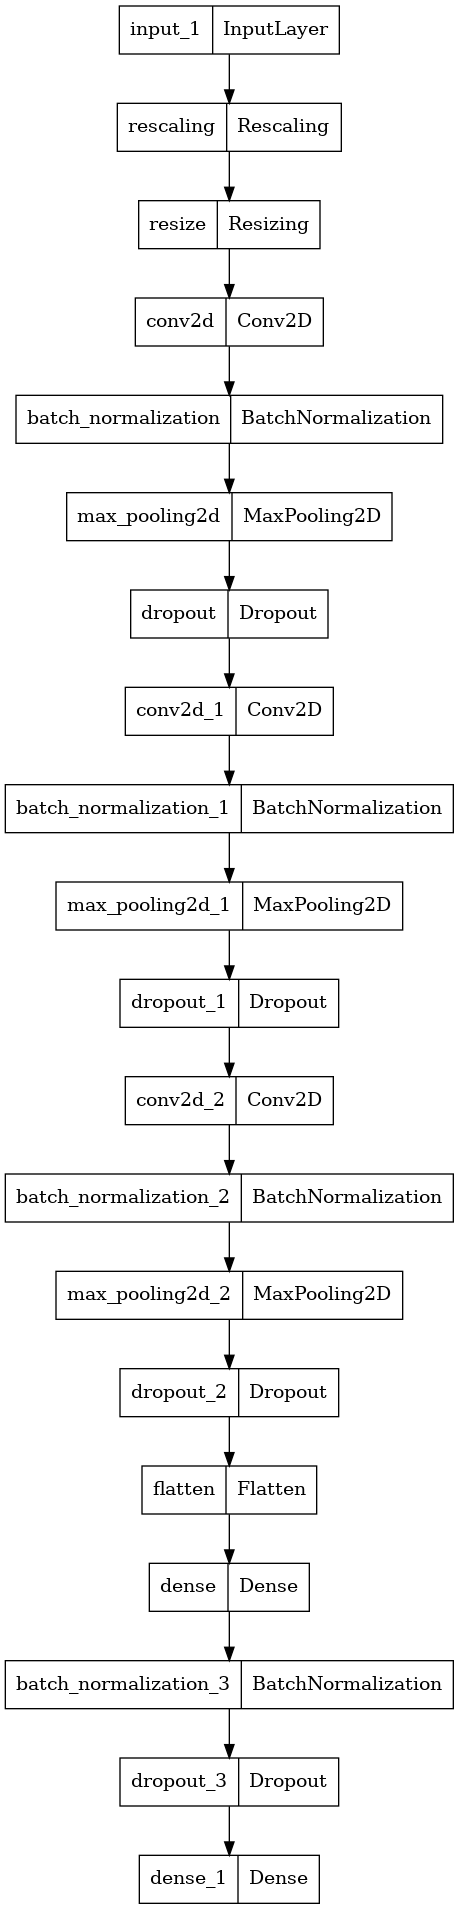

In [18]:
tf.keras.utils.plot_model(model,to_file='눈깜빡임모델.png',show_shapes=False)